<h1><strong><u>MLP Test</u></strong></h1>

In [23]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, CategoricalNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import spacy

<h2><u>Data Preprocessing</u></h2>

In [9]:
df = pd.DataFrame(columns=["title", "target"])

In [10]:
# Formatting text files
titles = []
targets = []
file_path_dict = {'clickbait': './clickbait_data.txt', 'non clickbait': './non_clickbait_data.txt'}
for key, value in file_path_dict.items():
    with open(value, 'r') as file:
        for line_number, line in enumerate(file):
            line = line.strip()
            if line != "":
                titles.append(line)
                targets.append(key)
data_dict = {"title": titles, "target": targets}
df = pd.DataFrame(data_dict)


In [11]:
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
display(data)

,title,target
0,Filipino activist arrested for disrupting Mani...,non clickbait
1,"International Board fixes soccer field size, h...",non clickbait
2,24 Rules For Women On A First Date With A Man,clickbait
3,Political fallout from the sacking of Professo...,non clickbait
4,"Which ""Clueless"" Character Are You Based On Yo...",clickbait
...,...,...
31995,Rocket strike near hotel in Afghan capital inj...,non clickbait
31996,How Well Do You Remember The First Episode Of ...,clickbait
31997,16 Photos From The Delhi Queer Pride Parade Th...,clickbait
31998,33 Of The Most Canadian Sentences Ever,clickbait


In [ ]:
X = data["title"]
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(25600,)

(6400,)

(25600,)

(6400,)

<h2><u>Data Vectorization</u></h2>

In [13]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

<h4><u>Cross Validation Testing</u></h4>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END clf__hidden_layer_sizes=(14,);, score=(train=0.956, test=0.936) total time=  54.0s
[CV] END clf__hidden_layer_sizes=(14,);, score=(train=0.959, test=0.934) total time=  56.6s
[CV] END clf__hidden_layer_sizes=(14, 3);, score=(train=0.995, test=0.949) total time= 1.8min
[CV] END clf__hidden_layer_sizes=(14, 5);, score=(train=0.996, test=0.952) total time= 2.1min
[CV] END clf__hidden_layer_sizes=(14, 3);, score=(train=0.996, test=0.952) total time= 2.5min
[CV] END clf__hidden_layer_sizes=(14,);, score=(train=0.959, test=0.941) total time=  57.2s
[CV] END clf__hidden_layer_sizes=(14, 2);, score=(train=0.996, test=0.951) total time= 3.4min
[CV] END clf__hidden_layer_sizes=(14, 4);, score=(train=0.996, test=0.954) total time= 3.4min
[CV] END clf__hidden_layer_sizes=(14, 2);, score=(train=0.995, test=0.954) total time= 1.8min
[CV] END clf__hidden_layer_sizes=(14, 5);, score=(train=0.996, test=0.950) total time= 3.3min
[CV] END clf__hidden_layer_sizes=(14,);, score=(train=0.956, test=

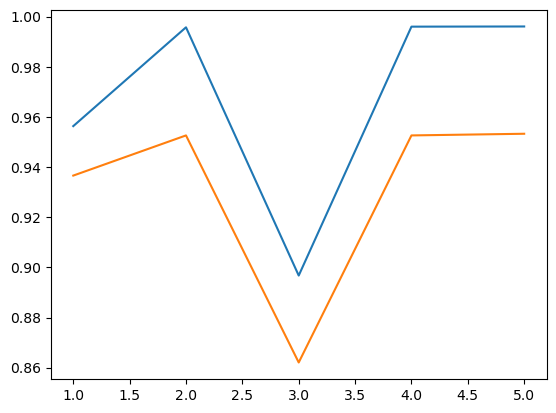

In [31]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", MLPClassifier(alpha=1, max_iter=500)),
    ]
)
hidden_layers_sizes = [(14,), (14,2), (14,3), (14,4), (14,5)]
neurons = list(range(4, 25, 4))
hidden_layers = list(range(1,6))
alphas = list(range(1,11))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers_sizes,
                                                   verbose=3,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(hidden_layers, train_scores_mean)
plt.plot(hidden_layers, validation_scores_mean)

<h2><u>Conclusion From Validation Curve</u></h2>

The shape of this plot suggest that adding hidden layers to the MLPClassifier object does not improve the generalization of the model. Going to hidden layer 2 makes the train scores shoot up to 1 while barely increasing the validation score at that point. From three hidden layers and beyond, both the training and the validation scores are completely parallel to each other which suggests that the generalization will remain the same at that point. Therefore, adding another hidden layer will have a detrimental effect on the generalization of the MLPClassifier.

<h4><u>Cross Validation Testing</u></h4>

In [25]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", MLPClassifier()),
    ]
)
param_grid = {
    "clf__hidden_layer_sizes": [(2,), (4,), (6,), (8,), (10,), (12,), (14,), (16,), (18,), (20,)],
    "clf__alpha": list(range(1,4))
    }

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
model.fit(X_train, y_train)
mlp_classifier = model.best_estimator_
model.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 2/5] END clf__alpha=1, clf__hidden_layer_sizes=(2,);, score=0.933 total time=   9.0s
[CV 4/5] END clf__alpha=1, clf__hidden_layer_sizes=(2,);, score=0.938 total time=   9.5s
[CV 3/5] END clf__alpha=1, clf__hidden_layer_sizes=(2,);, score=0.939 total time=   9.7s
[CV 1/5] END clf__alpha=1, clf__hidden_layer_sizes=(2,);, score=0.939 total time=  10.3s
[CV 3/5] END clf__alpha=1, clf__hidden_layer_sizes=(4,);, score=0.937 total time=  10.7s
[CV 1/5] END clf__alpha=1, clf__hidden_layer_sizes=(4,);, score=0.940 total time=  11.0s
[CV 5/5] END clf__alpha=1, clf__hidden_layer_sizes=(2,);, score=0.938 total time=  11.0s
[CV 2/5] END clf__alpha=1, clf__hidden_layer_sizes=(4,);, score=0.933 total time=  11.2s
[CV 5/5] END clf__alpha=1, clf__hidden_layer_sizes=(4,);, score=0.938 total time=  10.6s
[CV 4/5] END clf__alpha=1, clf__hidden_layer_sizes=(4,);, score=0.939 total time=  15.3s
[CV 1/5] END clf__alpha=1, clf__hidden_layer_siz

{'clf__alpha': 1, 'clf__hidden_layer_sizes': (14,)}

<h4><u>Multi-Layered Perceptron Training Metrics</u></h4>

In [26]:
mlp_training_values = cross_val_score(mlp_classifier, X_train, y_train, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", mlp_training_values)
np_mlp_training_values = np.array(mlp_training_values)
average = np.mean(np_mlp_training_values)
stDev = np.std(np_mlp_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.93691406 0.93242187 0.93945312 0.93847656 0.93691406]
0.94  +/-  0.0024 



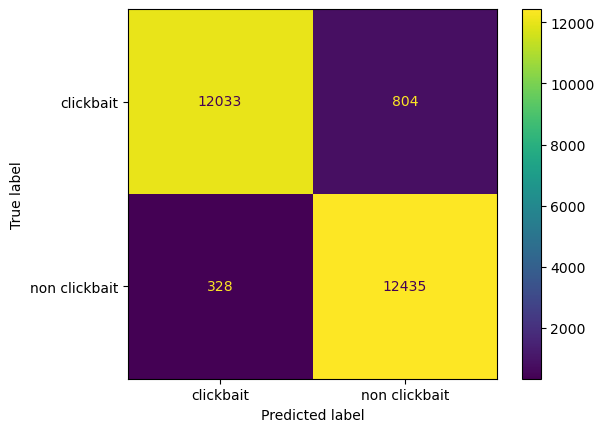

In [27]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(mlp_classifier, X_train, y_train)

<h4><u>Multi-Layered Perceptron Learning Curves</u></h4>

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_

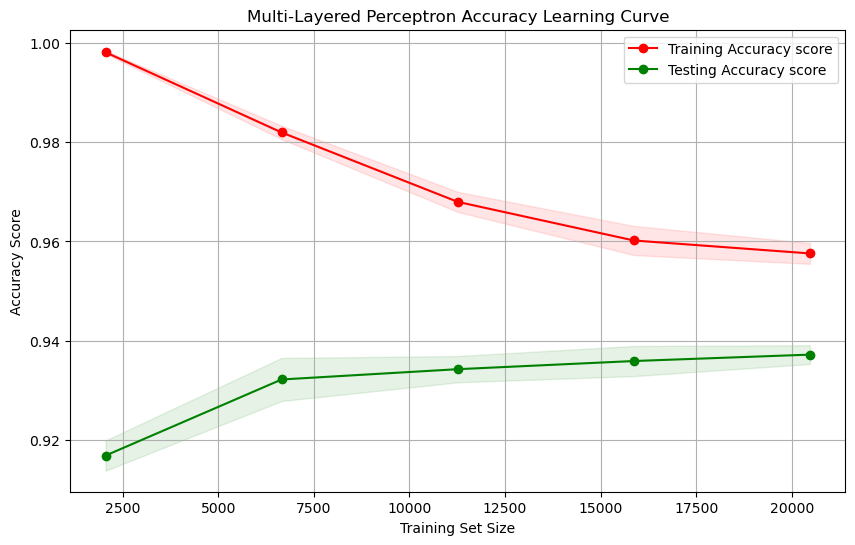

In [ ]:
mlp_train_sizes, mlp_train_scores, mlp_validation_scores = learning_curve(
    mlp_classifier,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
mlp_train_scores_mean = np.mean(mlp_train_scores, axis=1)
mlp_train_scores_std = np.std(mlp_train_scores, axis=1)
mlp_validation_scores_mean = np.mean(mlp_validation_scores, axis=1)
mlp_validation_scores_std = np.std(mlp_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Multi-Layered Perceptron Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(mlp_train_sizes, mlp_train_scores_mean - mlp_train_scores_std,
                mlp_train_scores_mean + mlp_train_scores_std, color="r")
plt.fill_between(mlp_train_sizes, mlp_validation_scores_mean - mlp_validation_scores_std,
                mlp_validation_scores_mean + mlp_validation_scores_std, color="g")
plt.plot(mlp_train_sizes, mlp_train_scores_mean, 'o-', color="r",
            label="Training Accuracy score")
plt.plot(mlp_train_sizes, mlp_validation_scores_mean, 'o-', color="g",
            label="Testing Accuracy score")

plt.legend(loc="best")
plt.show()

<h2><u>Conclusion From Learning Curve</u></h2>

<p> I believe that the overall shape of the learning curve is good. The training and the validation curves are diverging towards each other which suggests that the model is prioritizing the general logic of the dataset over being completely accurate. This model is a good model to move forward with but I do believe that it can be fine tuned. My next steps is to research the effect of adding more hidden layers to the model to see if the validation data learning curve accuracy score can increase while still retaining the shape of this previous learning curve.</p>
<p>Also, I will need to rerun the GridSearchCV with the max_iter higher than the default because of the ConvergenceWarnings for the learning curve. Probably between 500-1000 will be good.</p>

<h4><u>Multi-Layered Perceptron Testing Metrics</u></h4>

In [ ]:
# mlp_test_predictions = mlp_classifier.predict(X_test)

# mlp_test_accuracy = accuracy_score(y_test, mlp_test_predictions)
# print("Multi-layer Perceptron Test Accuracy: {:.2f}%".format(mlp_test_accuracy * 100))

Multi-layer Perceptron Test Accuracy: 94.36%


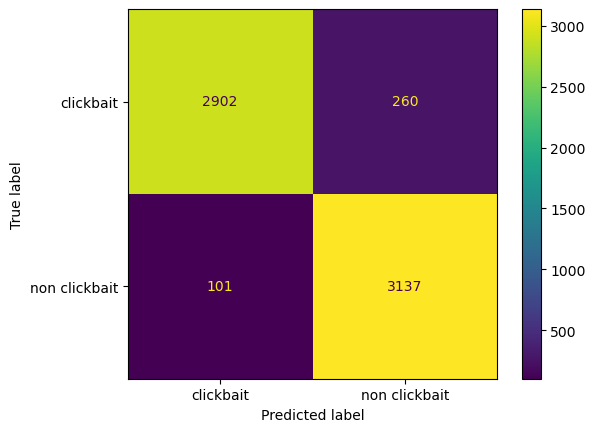

In [ ]:
# #Testing Confusion Matrix
# ConfusionMatrixDisplay.from_predictions(y_test, mlp_test_predictions)